In [ ]:
import soundfile as sf
import python_speech_features as mfcc
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
from tqdm import tqdm

In [2]:
def extract_features(audiof):
    audio,samplerate=sf.read(audiof);
    mfccs = mfcc.mfcc(audio, samplerate, 0.025, 0.01, 20, appendEnergy=True)
    return mfccs  

In [3]:
def enroll(utt2spk):
    spkMap={}
    f = open(utt2spk,'r')
    for line in f:
        line = line.strip()
        columns = line.split()
        if len(columns) == 4:
            spkMap[columns[0]] = columns[1:4]
        else:
            print("Error, expecting 4 columns in utt2spk for enroll")

    f.close()
    return spkMap

In [4]:
spkMap = enroll("../data/LibriSpeech/utt2spk.sid.enroll")

In [5]:
print(spkMap)

{'61': ['train-clean//61/70970/61-70970-0040.flac', 'train-clean//61/70970/61-70970-0017.flac', 'train-clean//61/70970/61-70970-0001.flac'], '5639': ['train-clean//5639/40744/5639-40744-0038.flac', 'train-clean//5639/40744/5639-40744-0002.flac', 'train-clean//5639/40744/5639-40744-0014.flac'], '6829': ['train-clean//6829/68769/6829-68769-0041.flac', 'train-clean//6829/68769/6829-68769-0016.flac', 'train-clean//6829/68769/6829-68769-0000.flac'], '908': ['train-clean//908/157963/908-157963-0015.flac', 'train-clean//908/157963/908-157963-0003.flac', 'train-clean//908/157963/908-157963-0019.flac'], '672': ['train-clean//672/122797/672-122797-0023.flac', 'train-clean//672/122797/672-122797-0074.flac', 'train-clean//672/122797/672-122797-0062.flac'], '8455': ['train-clean//8455/210777/8455-210777-0004.flac', 'train-clean//8455/210777/8455-210777-0053.flac', 'train-clean//8455/210777/8455-210777-0045.flac'], '8463': ['train-clean//8463/287645/8463-287645-0002.flac', 'train-clean//8463/287645/

In [6]:
spkMap['61']

['train-clean//61/70970/61-70970-0040.flac',
 'train-clean//61/70970/61-70970-0017.flac',
 'train-clean//61/70970/61-70970-0001.flac']

In [7]:
GMM_COMPONENTS=32
baseDir="../data/LibriSpeech"

In [8]:
gmm_speakers = {}

In [9]:
for speaker_id in spkMap:
    gmm_speakers[speaker_id] = GMM(n_components = GMM_COMPONENTS, covariance_type='diag')
    feature_vect = np.array(())

    for audioPath in spkMap[speaker_id]:
        speaker_feats = extract_features(baseDir+"/"+audioPath)
        if feature_vect.size == 0:
            feature_vect = speaker_feats
        else:
            feature_vect = np.vstack((feature_vect, speaker_feats))
            
    print(feature_vect.shape)
    gmm_speakers[speaker_id].fit(feature_vect)
    print("Saving speaker model for speaker ",speaker_id)  

(1283, 20)
Saving speaker model for speaker  61
(3040, 20)
Saving speaker model for speaker  5639
(1844, 20)
Saving speaker model for speaker  6829
(3895, 20)
Saving speaker model for speaker  908
(2107, 20)
Saving speaker model for speaker  672
(2604, 20)
Saving speaker model for speaker  8455
(2381, 20)
Saving speaker model for speaker  8463


In [10]:
def verify(utt2spk_verify, speakerStruct):

    pred_scores = []
    labels = []
    f = open(utt2spk_verify,'r')
    for line in tqdm(f):
        line = line.strip()
        columns = line.split()
        if len(columns) == 3:
            test_feats = extract_features(baseDir+"/"+columns[1])
            score = np.array(speakerStruct[columns[0]].score(test_feats)).sum()
            pred_scores.append(score)
            if columns[2] == "TARGET":
                labels.append(1)
            else:
                labels.append(0)

        else:
            print("Error, expecting 3 columns in verifyMap")

    f.close()
    return(labels, pred_scores)

In [11]:
labels, pred_scores = verify("../data/LibriSpeech/utt2spk.sid.verify",gmm_speakers)

4305it [00:56, 76.04it/s] 


In [13]:
from sklearn.metrics import roc_curve, auc

In [14]:
fpr, tpr, _ = roc_curve(labels, pred_scores)
roc_auc = auc(fpr,tpr)

print("AUC ",roc_auc)

AUC  0.8915458176081585


Text(0, 0.5, 'True Positive Rate')

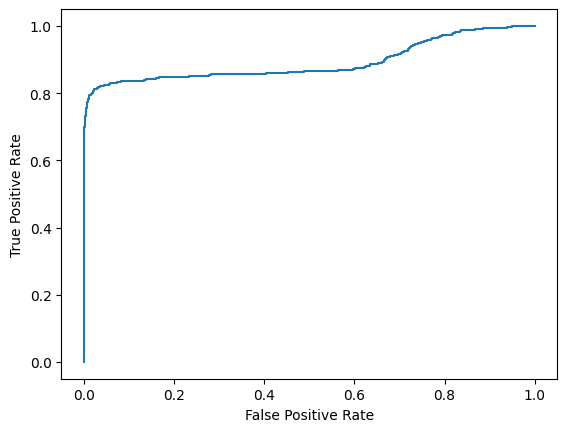

In [15]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr, label= 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Generating UBM

In [16]:
import os

def generate_all_features(dir):
    features = np.asarray(())
    for path, dirs, files in os.walk(dir):
        for file in files:
            if 'flac' in file:
                af = os.path.join(path,file)
                if features.size == 0:
                    features = extract_features(af)
                else:
                    features = np.vstack((features, extract_features(af)))
    return features

In [17]:
all_feats = generate_all_features("../data/LibriSpeech/train-clean")

In [18]:
np.random.shuffle(all_feats)
smallSet = all_feats[:1000000,:]
print(smallSet.shape)

(1000000, 20)


In [19]:
ubm = GMM(n_components = GMM_COMPONENTS, covariance_type = 'diag')
ubm.fit(smallSet)

GaussianMixture(covariance_type='diag', n_components=32)

In [21]:
import copy

def map_adapt(ubm, X, max_iter = 100, r = 16):
    gmm = copy.deepcopy(ubm)

    for _ in range(max_iter):
        n = np.sum(gmm.predict_proba(X), axis=0).reshape(-1,1)
        n = n+0.001
        X_tilde = (1/n) * gmm.predict_proba(X).T.dot(X)
        
        alpha = (n/n+r).reshape(-1,1)
        gmm.means_ = alpha * X_tilde + (1-alpha) * gmm.means_
        
    return gmm   

In [22]:
def map_adapt2(ubm, X, max_iter=100, r=25):
    
    gmm = copy.deepcopy(ubm)
    
    for _ in range(max_iter):
        n = np.sum(gmm.predict_proba(X), axis=0).reshape(-1, 1)
        n = n + 0.001
        #print(n)
        X_tilde = (1 / n) * gmm.predict_proba(X).T.dot(X) 
        alpha = (n / (n + r)).reshape(-1, 1)
        gmm.means_ = alpha * X_tilde + (1 - alpha) * gmm.means_
    
    return gmm

In [23]:
map_speakers = {}

for speaker_id in spkMap:
    feature_vect = np.array(())

    for audioPath in spkMap[speaker_id]:
        speaker_feats = extract_features(baseDir+"/"+audioPath)
        if feature_vect.size == 0:
            feature_vect = speaker_feats
        else:
            feature_vect = np.vstack((feature_vect, speaker_feats))
            
    print(feature_vect.shape)
    map_speakers[speaker_id] = map_adapt2(ubm, feature_vect)
    print("Saving map speaker model for speaker ",speaker_id) 

(1283, 20)
Saving map speaker model for speaker  61
(3040, 20)
Saving map speaker model for speaker  5639
(1844, 20)
Saving map speaker model for speaker  6829
(3895, 20)
Saving map speaker model for speaker  908
(2107, 20)
Saving map speaker model for speaker  672
(2604, 20)
Saving map speaker model for speaker  8455
(2381, 20)
Saving map speaker model for speaker  8463


In [24]:
labels_map, pred_scores_map = verify("../data/LibriSpeech/utt2spk.sid.verify", map_speakers)

4305it [00:51, 84.34it/s] 


In [25]:
fpr_map, tpr_map, _ = roc_curve(labels_map, pred_scores_map)
roc_auc_map = auc(fpr_map,tpr_map)

print("AUC ",roc_auc_map)

AUC  0.8952593024437357


Text(0, 0.5, 'True Positive Rate')

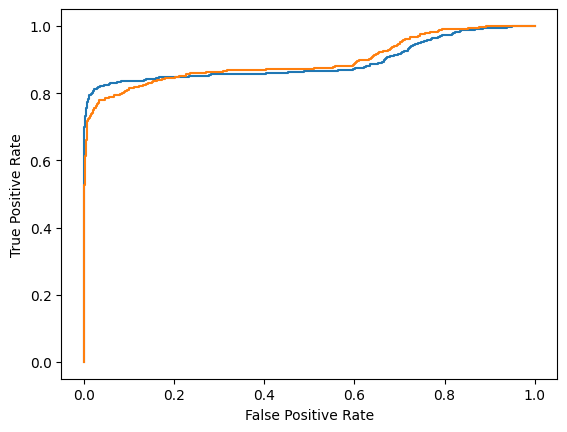

In [26]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr, label= 'ROC curve')
plt.plot(fpr_map,tpr_map, label= 'ROC curve MAP')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')